# AutoEncoder Meet Collaborative Filtering

- Collaborative Filtering을 위해 user-item matrix 만들기
- AutoEncoder 모델 구조 정의하기
- Training Deep AutoEncoder 논문은 [저자 코드](https://github.com/NVIDIA/DeepRecommender) 참고

## 논문 종류
- AutoRec
- Training Deep AutoEncoder
- Variational AutoEncoder

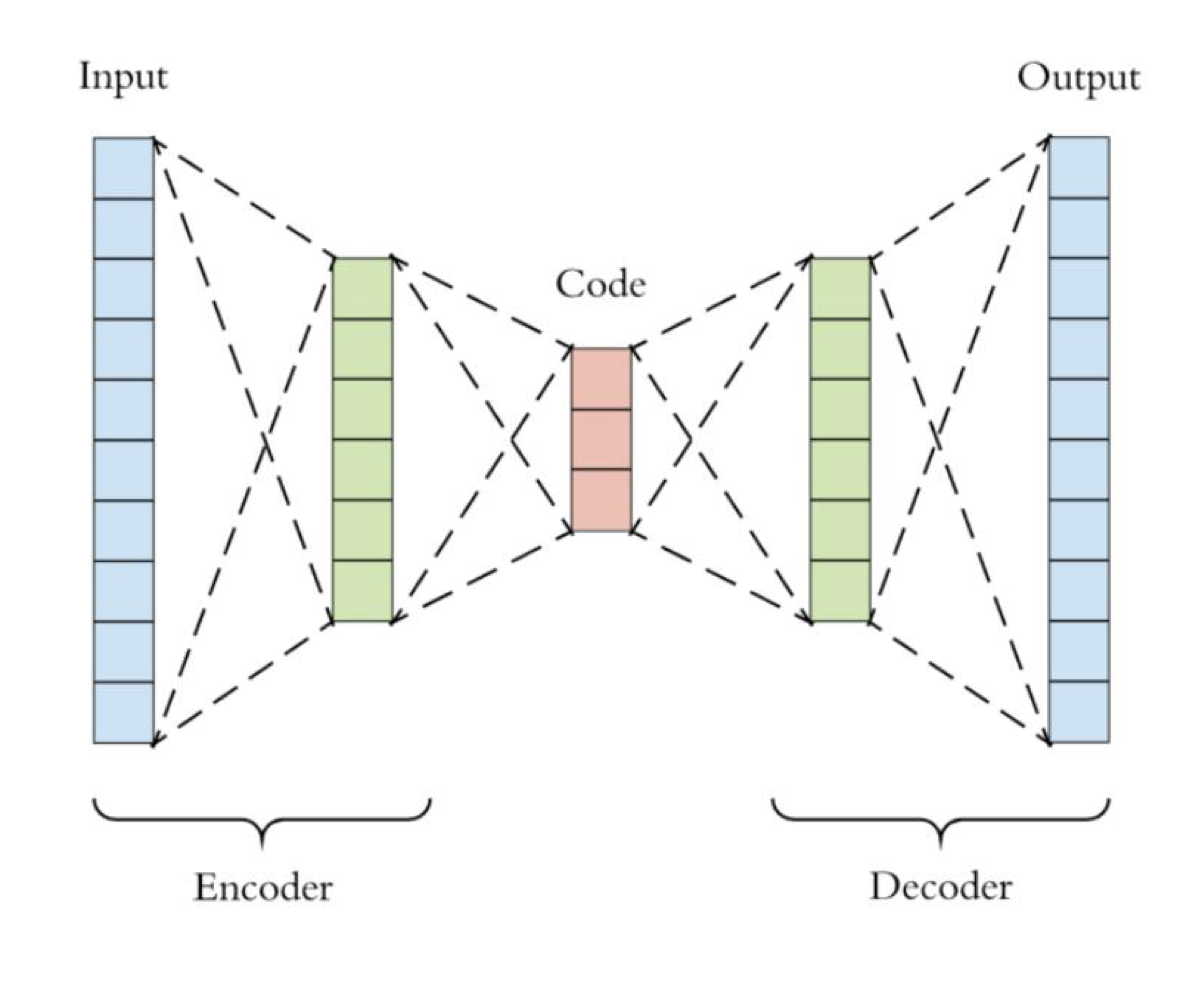

## 1. Data Loader 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/My Drive/data/kmrd/kmr_dataset/datafile/kmrd-small'

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torch
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.init as weight_init

In [ ]:
def read_data(data_path):
    df = pd.read_csv(os.path.join(data_path,'rates.csv'))[:10000]
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=1234, shuffle=True)

    user_to_index = {original: idx for idx, original in enumerate(df.user.unique())}
    movie_to_index = {original: idx for idx, original in enumerate(df.movie.unique())}

    return train_df, val_df, user_to_index, movie_to_index

In [ ]:
class KMRDdataset(Dataset):
    def __init__(self, df, user_to_index, movie_to_index, item_based=True):
        self.min_rating = min(df.rate)
        self.max_rating = max(df.rate)

        # user의 기존 value를 user_to_index를 통해 재설정된 index로 변환
        self.user = [user_to_index[u] for u in df.user.values]

        # movie의 기존 value를 movie_to_index를 통해 재설정된 index로 변환
        self.movie = [movie_to_index[m] for m in df.movie.values]
        self.rating = df.rate.values

        if item_based:
          input_tensor = torch.LongTensor([self.movie, self.user])

          # torch.sparse : http://man.hubwiz.com/docset/PyTorch.docset/Contents/Resources/Documents/sparse.html
          '''
            ex) input_tensor = [
                  [0, 15, 466] => movie의 index, 
                  [0, 50, 532] => user의 index
                ],
                
                rating = [0, 3, 5] => 15번째 row, 50번째 column에 3을 넣는다                
          '''      
          self.data = torch.sparse.FloatTensor(input_tensor, torch.FloatTensor(self.rating),
                                             torch.Size([len(movie_to_index), len(user_to_index)])).to_dense()
          # | self.data | = ( movie_count, user_count )                                     
        else:
          input_tensor = torch.LongTensor([self.user, self.movie])
          self.data = torch.sparse.FloatTensor(input_tensor, torch.FloatTensor(self.rating),
                                             torch.Size([len(user_to_index), len(movie_to_index)])).to_dense()
          # | self.data | = ( user_count, movie_count )

    def __len__(self):
      return len(self.data)
    
    def __getitem__(self, idx):
      return self.data[idx]

In [ ]:
train_df, val_df, user_to_index, movie_to_index = read_data(data_path=data_path)

In [ ]:
train_dataset = KMRDdataset(train_df, user_to_index, movie_to_index)
val_dataset = KMRDdataset(val_df, user_to_index, movie_to_index)

In [ ]:
print(train_df.shape)
print(train_dataset.data[0].size())
print(len(train_dataset))
print(val_df.shape)
print(val_dataset.data[0].size())

(8000, 4)
torch.Size([466])
532
(2000, 4)
torch.Size([466])


In [ ]:
print(len(list(movie_to_index.keys())))

532


In [ ]:
train_dataset.data[0]

tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0., 27.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  8.,  9.,  0., 10.,  0.,  9.,  0.,  0.,
         0.,  0.,  5.,  0.,  0.,  0.,  0., 10.,  0.,  0.,  0.,  9.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,
         0.,  0.,  0.,  0.,  0., 10.,  0.,  1.,  0.,  0.,  0., 10.,  0.,  0.,
         0.,  0.,  0.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  8.,  0.,  0., 10.,  0.,  0., 10.,  0.,  0.,  0.,
         0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  9.,  0.,  0., 1

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

## AutoEncoder Modeling

In [ ]:
class SimpleAutoEncoder(nn.Module):
  def __init__(self, num_inputs, num_hiddens, kind='sigmoid', dropout=None):
    super(SimpleAutoEncoder, self).__init__()
    # encoder -> hidden -> decoder
    # input -> hidden -> output
    # input -> hidden : encoder
    # hidden -> output = input : decoder
    self.encoder = nn.Sequential(nn.Linear(num_inputs, num_hiddens), self.activation(kind))
    self.decoder = nn.Sequential(nn.Linear(num_hiddens, num_inputs), self.activation(kind))  

  def activation(self, kind):
    if kind == 'selu':
      return nn.SELU()
    elif kind == 'relu':
      return nn.ReLU()
    elif kind == 'relu6':
      return nn.ReLU6()
    elif kind == 'sigmoid':
      return nn.Sigmoid()
    elif kind == 'tanh':
      return nn.Tanh()
    elif kind == 'elu':
      return nn.ELU()
    elif kind == 'lrelu':
      return nn.LeakyReLU()
    elif kind == 'none':
      return input
    else:
      raise ValueError('Unknown non-linearity type')

  def forward(self, x):
    return self.decoder(self.encoder(x))

In [ ]:
class DeepAutoEncoder(nn.Module):
  def __init__(self, num_hiddens, num_layers, dropout=None, nn_type='diamond'):
    super(AutoEncoder, self).__init__()
    # input -> hidden -> output
    # input -> hidden(10) -> ... -> hidden(10) -> output = input
    self.encoder, self.decoder = self.generate_layers(num_hiddens, num_layers, dropout, nn_type)
  
  def forward(self, x):
    return self.decoder(self.encoder(x))
  
  def generate_layers(self, num_hiddens, num_layers, dropout=None, nn_type='diamond'):
    # hidden layers -> [50, 25, 12, 6, 6, 12, 25, 50], [100 50 100] -> 100, 50, 60, 50 100 
    if nn_type == 'diamond':
      encoder_modules = []
      decoder_modules = []

      hidden_layers = []
      temp = num_hiddens
      for idx, x in enumerate(range(num_layers)):
        if idx == 0:
          hidden_layers.append(temp)
        else:
          hidden_layers.append(int(temp/2))
        temp = temp/2
      hidden_layers = [x for x in hidden_layers if x > 10]
      
      # encoder
      for idx, num_hidden in enumerate(hidden_layers):
        if idx < len(hidden_layers)-1:
          encoder_modules.append(nn.Linear(hidden_layers[idx], hidden_layers[idx+1], bias=True))
          encoder_modules.append(nn.Sigmoid())

      # decoder
      hidden_layers = list(reversed(hidden_layers))
      for idx, num_hidden in enumerate(hidden_layers):
        if idx < len(hidden_layers)-1:
          decoder_modules.append(nn.Linear(hidden_layers[idx], hidden_layers[idx+1], bias=True))
          decoder_modules.append(nn.Identity())

    # num_hidden = 50, num_layers = 3 ->  input_dim -> [50, 50, 50] -> output_dim = input_dim 
    elif nn_type == 'constant':
      hidden_layers = [num_hiddens] * num_layers
      for idx, enc in enumerate(hidden_layers):
        if idx < num_layers-1:
          encoder_modules.append(nn.Linear(hidden_layers[idx], hidden_layers[idx+1], bias=True))
          encoder_modules.append(nn.Sigmoid())
          decoder_modules.append(nn.Linear(hidden_layers[idx], hidden_layers[idx+1], bias=True))
          decoder_modules.append(nn.Identity())

    if dropout is not None:    
      encoder_modules = [x for y in (encoder_modules[i:i+2] + [nn.Dropout(dropout)] * (i < len(encoder_modules) - 1) 
                          for i in range(0, len(encoder_modules), 2)) for x in y]
      decoder_modules = [x for y in (decoder_modules[i:i+2] + [nn.Dropout(dropout)] * (i < len(decoder_modules) - 1)
                          for i in range(0, len(decoder_modules), 2)) for x in y]

    encoder = nn.Sequential(*encoder_modules)
    decoder = nn.Sequential(*decoder_modules)
    
    return encoder, decoder

## Training

In [ ]:
num_users = len(user_to_index.keys())
num_movies = len(movie_to_index.keys())
print(num_users, num_movies)

466 532


In [ ]:
model = SimpleAutoEncoder(num_inputs=num_users, num_hiddens=100, kind='selu')
model

SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=466, out_features=100, bias=True)
    (1): SELU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=466, bias=True)
    (1): SELU()
  )
)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        torch.nn.init.zeros_(m.bias)

model.apply(weights_init)

SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=466, out_features=100, bias=True)
    (1): SELU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=100, out_features=466, bias=True)
    (1): SELU()
  )
)

In [ ]:
train_dataset.data[0].size()

torch.Size([466])

In [ ]:
# NVIDIA Recommender System 참고
# size_average -> loss의 평균값을 구할 때 true, loss 합계 구할 때 false
def MSEloss(inputs, targets, size_average=False):
  # target 값이 0일 때는 loss 구하지 않음 (일종의 가중치 개념)
  mask = targets != 0
  num_ratings = torch.sum(mask.float())
  criterion = nn.MSELoss(reduction='sum' if not size_average else 'mean')
  return criterion(inputs * mask.float(), targets), Variable(torch.Tensor([1.0])) if size_average else num_ratings

In [ ]:
model.train()
train_loss = 0
for idx, batch in enumerate(train_dataloader):
    optimizer.zero_grad()
    pred = model(batch)
    loss, num_ratings = MSEloss(pred, batch)    
    # num_ratings = 1 or num_ratings
    loss = torch.sqrt(loss / num_ratings)
    loss.backward()
    train_loss += loss.item() 
    optimizer.step()
    
    print(train_loss / (idx+1))

12.40528678894043
10.6390061378479
10.365818659464518
10.042583703994751
9.970010375976562
10.300945917765299
10.365781511579241
10.74490487575531
10.521301799350315


In [ ]:
model.eval()
val_loss = 0
with torch.no_grad():
  for idx, batch in enumerate(val_dataloader):
    pred = model(batch)
    loss, num_ratings = MSEloss(pred, batch)
    loss = torch.sqrt(loss / num_ratings)
    val_loss += loss.item()

    print(val_loss/(idx+1))

7.575638771057129
7.563446998596191
7.821440696716309
7.836154937744141
8.141081428527832
8.163790384928385
8.168331010001046
8.396627426147461
8.386043124728733
8.434664154052735
8.395286386663264
8.456267277399698
8.513283436114971
8.474042075020927
8.447132428487143
8.410951048135757
8.471563759972067
8.475589089923435
8.43731709530479
8.431968688964844
8.41148871467227
8.405101125890559
8.444677933402684
8.427778601646423
8.420968017578126
8.525918630453257
8.529303621362757
8.512095076697213
8.499287375088397
8.515808963775635
8.54619324591852
8.533594787120819
8.541880116318211
8.524153134402107
